<h1><center> DAVID MONTAÑO CASTRO TAREA 1. </center></h1>

<h1><center> EJERCICIO 1, PRIMERA TAREA. </center></h1>

A partir de los siguientes datos

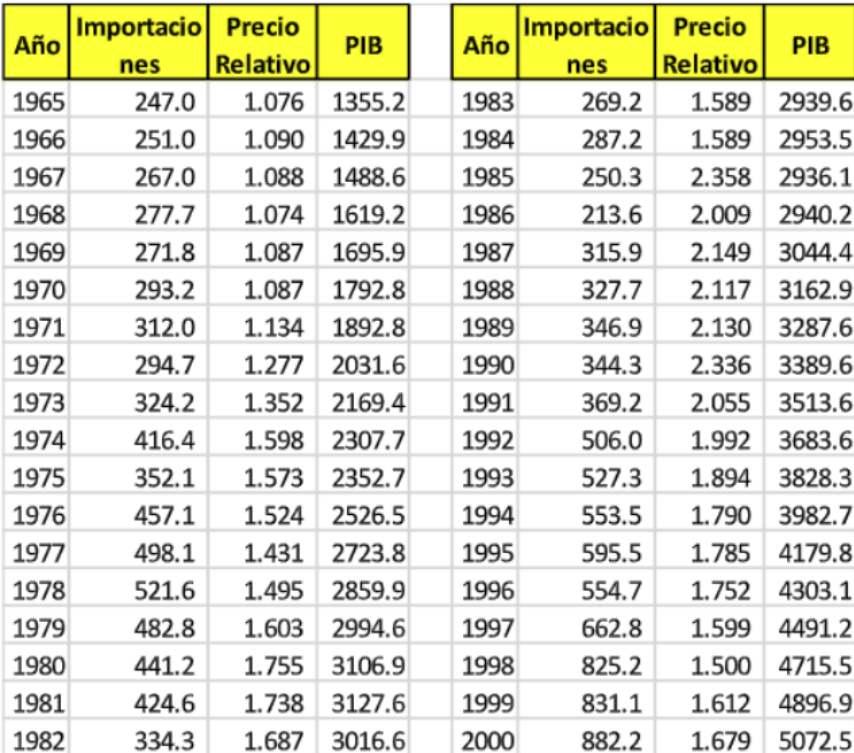

a) Ajustar la variable de respuesta PIB con un modelo de regresión múltiple respecto a las otras columnas.

b) Realizar un diagnóstico de los residuales y encaso de que no se cumplan algunos de los supuestos, solucionarlos.

### Descargar librerías

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white as white
import numpy as np

plt.rcParams["figure.figsize"] = (20,15)
plt.style.use('seaborn-poster')

### Importar información

In [2]:
df = pd.read_excel("TE1_EJ1_MONTAÑO_CASTRO_DAVID.xlsx") ; df.head(3)

,Año,Importaciones,Precio Relativo,PIB
0,1965,247.0,1.076,1355.2
1,1966,251.0,1.090,1429.9
2,1967,267.0,1.088,1488.6


### Análisis rápido

Movimientos al alza por parte de las tres variables a analizar. Ambas variables predictoras tienen un comportamiento contrario (20), pero no puedo asegurar que esto implica correlación negativo pues en el principio seguían la misma tendencia positiva.

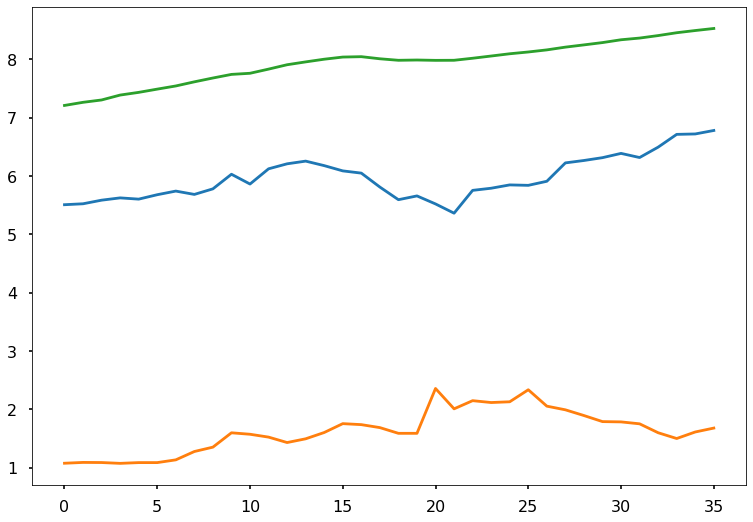

In [3]:
np.log(df.Importaciones).plot()
df["Precio Relativo"].plot()
np.log(df.PIB).plot()

La relación lineal entre importacones y el Precio Relativo es positiva pero muy debil.
No es buena idea incluir como variables predictora al Año porque muestra una __muy fuerte__ relación lineal con ambas variables Importaciones y el Precio Relativo. Además, el año constituye un elemento de una serie de tiempo. 

(array([0.5, 1.5, 2.5, 3.5]), <a list of 4 Text major ticklabel objects>)

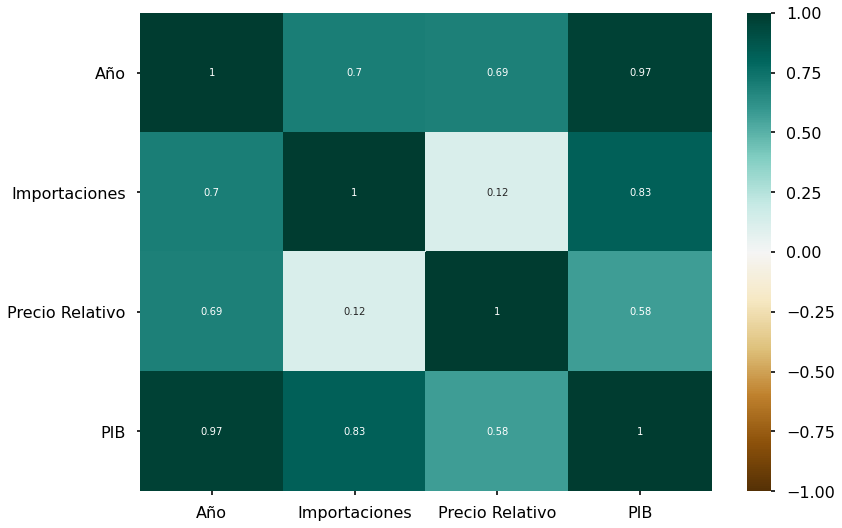

In [4]:
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.yticks(rotation = "horizontal")

En cuanto a la relación que tiene cada variable dependiente respecto a la variable a predecir PIB, se observa que Año tiene una correlación casi perfecta, pero por los motivos antes mencionados se descartará del análisis. 
Después sigue Importaciones con .83 y al final Precio relativo, con .58. A mi criterio, las relaciones lineales no son débiles y podrían constituir un buen modelo.

(array([0.5, 1.5, 2.5, 3.5]), <a list of 4 Text major ticklabel objects>)

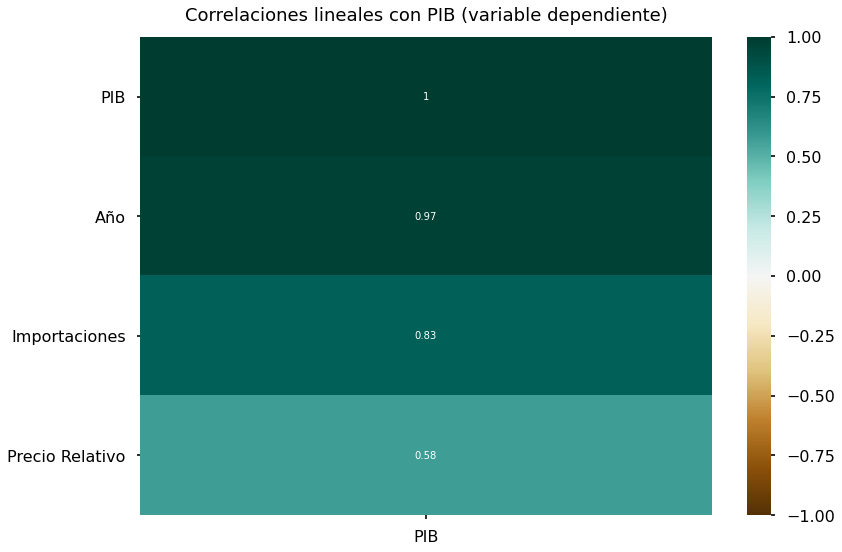

In [5]:
heatmap = sns.heatmap(df.corr()[['PIB']].sort_values(by='PIB', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlaciones lineales con PIB (variable dependiente)', fontdict={'fontsize':18}, pad=16)
plt.yticks(rotation = "horizontal")

### Modelo de regresión

In [6]:
df.head(1)

,Año,Importaciones,Precio Relativo,PIB
0,1965,247.0,1.076,1355.2


__OBSERVACIÓN__: Las escalas entre variables son muy diversas. Esto puede llegar a causar y confundir al modelo, asignando malas inferencias en los parámetros y en las conclusiones; es decir, podría llegar a aumentar la heterocedasticidad. Es por ello que llevaré a cabo un reescalamiento en los datos de forma que estos a lo mucho tengan una cifra decimal. Esto es valido pues es una diferente representación de los datos pero en esencia es el mismo valor. 

In [7]:
df.Importaciones = df.Importaciones/100
df.PIB = df.PIB/1000

In [8]:
X = df.drop(columns = ["Año","PIB"])
Y = df.PIB 

#### Primer modelo: Variables en crudo

In [9]:
Xreg = sm.add_constant(X)
Yreg = Y

model1 = sm.OLS(Yreg, Xreg, prepend=True).fit()
display(model1.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    PIB   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     177.9
Date:                Sat, 20 Nov 2021   Prob (F-statistic):           2.11e-18
Time:                        18:08:47   Log-Likelihood:                -6.3948
No. Observations:                  36   AIC:                             18.79
Df Residuals:                      33   BIC:                             23.54
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.0390      0.251     -4.141      0.000      -1.549      -0.529
Importaciones       0.4470      0.030     15.043      0.000       0.387       0.507
Precio Relativo     1.3239      0.140      9.481      0.000       1.040       1.608
==============================================================================
Omnibus:                        1.384   Durbin-Watson:                   1.001
Prob(Omnibus):                  0.500   Jarque-Bera (JB):                0.796
Skew:                           0.360   Prob(JB):                        0.672
Kurtosis:                       3.106   Cond. No.                         27.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

__OBSERVACIÓN__: Todos los indicadores lucen adecuados __excepto por el test de autocorrelación de Durbin-Watson__. Además, tengo que checar la heterocedasticidad del modelo, lo cuál no incluye por defecto el resumen de statsmodels. Para este caso, incluiré el __test de White__. 

>>>>> Ho: No hay presencia de heterocedasticidad vs Ha: Hay presencia de heretocedasticidad

Se concluye a un nivel de confianza del 95 que el modelo tiene problemas de heterocedasticidad.

In [10]:
print("LM-test: ", white(model1.resid,Xreg)[1], 2*"\n", "F-test: ", white(model1.resid,Xreg)[3])

LM-test:  0.02923202694955012 

 F-test:  0.02055118946618899


##### Diagnóstico de los residuales 
Antes de tratar de corregir tanto la autocorrelación como la heterocedasticidad, voy a darle tratamiento a los residuales por medio de la Distancia de Cook. De esta manera, tengo certeza de que la heterocedasticidad debería disminuir pues quitaremos puntos que apalanquen al modelo. Esto es como primer acercamiento, pues como lo mencione, la distancia de Cook (apalancamiento) no detecta eficientemente a los puntos alejados de la mayoría que están por "en medio" de la recta. En ese caso, tendría que utilizar la Distancia de Mahalanobis. 

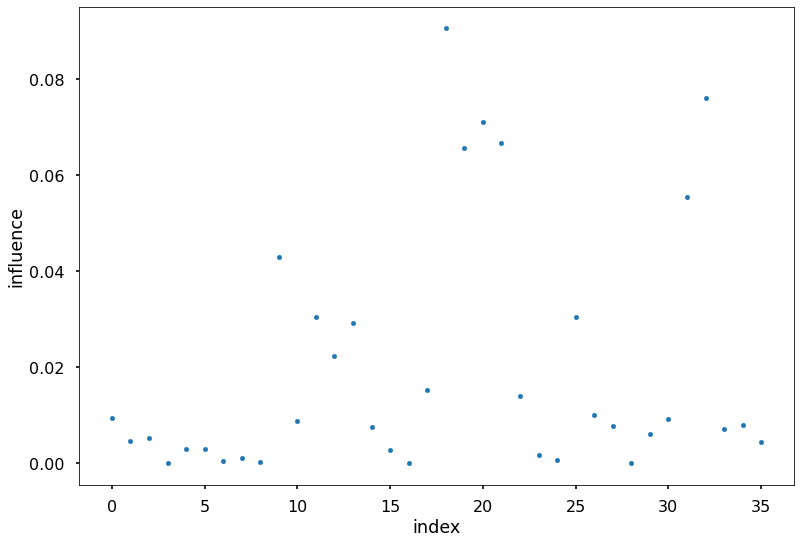

In [11]:
influence = model1.get_influence()
c,p = influence.cooks_distance
influence_df = Xreg
influence_df['influence'] = c
influence_df["influence"].reset_index().plot(kind = "scatter", x = "index", y = "influence")

In [12]:
influence_df = influence_df[influence_df['influence']<=.072] 
Xreg_noinf = sm.add_constant(df.loc[influence_df.index,"Importaciones":"Precio Relativo"])
Yreg_noinf = df.loc[influence_df.index,"PIB"]


In [13]:
model1_ = sm.OLS(Yreg_noinf,Xreg_noinf,prepend=True).fit()
display(model1_.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    PIB   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     206.2
Date:                Sat, 20 Nov 2021   Prob (F-statistic):           1.23e-18
Time:                        18:08:47   Log-Likelihood:                -2.5689
No. Observations:                  34   AIC:                             11.14
Df Residuals:                      31   BIC:                             15.72
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.0817      0.229     -4.728      0.000      -1.548      -0.615
Importaciones       0.4456      0.028     15.892      0.000       0.388       0.503
Precio Relativo     1.3334      0.127     10.536      0.000       1.075       1.592
==============================================================================
Omnibus:                        1.421   Durbin-Watson:                   1.316
Prob(Omnibus):                  0.491   Jarque-Bera (JB):                0.557
Skew:                           0.242   Prob(JB):                        0.757
Kurtosis:                       3.400   Cond. No.                         26.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
print("LM-test: ", white(model1_.resid,Xreg_noinf)[1], 2*"\n", "F-test: ", white(model1_.resid,Xreg_noinf)[3])

LM-test:  0.07354769042676626 

 F-test:  0.06657465116015039


No solamente he conseguido que la heterocedasticidad disminuya (ya se rechaza la hipótesis nula de la prueba de White), si no que también he conseguido que la $R^2$ ajustada, la F-statistic, el Log-Likelihood, AIC, BIC, la desviación estandar de los estimadores, la prueba de DW (aún hay correlaciópn) y la prueba de JB mejoraran. 

__NOTA__: Tuve que sacrificar dos valores de la serie para poder tener todas estas mejoras. Preferí lo anterior a tener que lidiar con procedimientos más complejos como una escalación normal o minmax, incluso asistirme de la distancia de mahalanobis.

### Segundo modelo: Arreglar el problema de autocorrelación.

Primero, me gustaría asegurarme si los residuales muestran algún tipo de autocorrelación (elementos que puedo aprovechar y que siguen descartandose). Esto lo llevaré a cabo con el __test de Ljung-Box__

>>>>> Ho: Los residuales se distribuyen de manera independiente vs Ha: Los residuales exhiben correlación serial

Desafortunadamente mis residuales están demasiado correlacionados, pues ninguno pasa la prueba. Lo que es más, todos rechazan la hipótesis nula con un valor muy bajo.

In [15]:
sm.stats.acorr_ljungbox(model1_.resid,lags=15, return_df  = True)

,lb_stat,lb_pvalue
1,4.286542,0.038415
2,11.053884,0.003978
3,11.868737,0.007847
4,12.478925,0.014123
5,12.794281,0.025385
6,17.881578,0.006535
7,19.586413,0.006536
8,21.058021,0.006995
9,23.163280,0.005840
10,25.621921,0.004283


#### Alternativa: ¿Necesito ambas variables?

##### Modelo sin variable Importaciones

In [16]:
Xreg_noinf_no_importaciones = Xreg_noinf.drop(columns = "Importaciones") 
Yreg_noinf_no_importaciones = Yreg_noinf

model1_sin_importaciones = sm.OLS(Yreg_noinf_no_importaciones,Xreg_noinf_no_importaciones,prepend=True).fit()
display(model1_sin_importaciones.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    PIB   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     18.05
Date:                Sat, 20 Nov 2021   Prob (F-statistic):           0.000173
Time:                        18:08:47   Log-Likelihood:                -40.196
No. Observations:                  34   AIC:                             84.39
Df Residuals:                      32   BIC:                             87.45
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.3647      0.625      0.584      0.564      -0.908       1.637
Precio Relativo     1.5877      0.374      4.249      0.000       0.826       2.349
==============================================================================
Omnibus:                       12.446   Durbin-Watson:                   0.171
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               12.060
Skew:                           1.348   Prob(JB):                      0.00240
Kurtosis:                       4.115   Cond. No.                         10.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Modelo sin variable Precio Relativo

In [17]:
Xreg_noinf_no_precio = Xreg_noinf.drop(columns = "Precio Relativo") 
Yreg_noinf_no_precio = Yreg_noinf

model1_sin_precio = sm.OLS(Yreg_noinf_no_precio,Xreg_noinf_no_precio,prepend=True).fit()
display(model1_sin_precio.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    PIB   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     67.93
Date:                Sat, 20 Nov 2021   Prob (F-statistic):           2.05e-09
Time:                        18:08:47   Log-Likelihood:                -28.442
No. Observations:                  34   AIC:                             60.88
Df Residuals:                      32   BIC:                             63.94
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.9356      0.264      3.546      0.001       0.398       1.473
Importaciones     0.4830      0.059      8.242      0.000       0.364       0.602
==============================================================================
Omnibus:                       17.883   Durbin-Watson:                   0.203
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                3.192
Skew:                           0.160   Prob(JB):                        0.203
Kurtosis:                       1.534   Cond. No.                         12.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

__CONCLUSIÓN__: Si necesito ambas variables, pero observando ambas pruebas de DW, la que peor desempeño tiene es cuando quito la variable _Importaciones_. Ajustaré un modelo tomando la primera diferencia de esta variable para corregir problemas de estacionariedad y si es necesario, de estacionalidad.

In [18]:
Xreg_noinf_diff = Xreg_noinf[["const","Importaciones"]].shift().dropna().join(Xreg_noinf["Precio Relativo"].diff().dropna())
Yreg_noinf_shift = Yreg_noinf.diff().dropna()

In [19]:
model2_shifted = sm.OLS(Yreg_noinf_shift, Xreg_noinf_diff, prepend=True).fit()
display(model2_shifted.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    PIB   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     3.651
Date:                Sat, 20 Nov 2021   Prob (F-statistic):             0.0381
Time:                        18:08:47   Log-Likelihood:                 36.992
No. Observations:                  33   AIC:                            -67.98
Df Residuals:                      30   BIC:                            -63.49
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0214      0.042      0.515      0.610      -0.063       0.106
Importaciones       0.0230      0.010      2.392      0.023       0.003       0.043
Precio Relativo    -0.0864      0.079     -1.095      0.282      -0.248       0.075
==============================================================================
Omnibus:                        8.058   Durbin-Watson:                   1.423
Prob(Omnibus):                  0.018   Jarque-Bera (JB):               12.690
Skew:                          -0.297   Prob(JB):                      0.00176
Kurtosis:                       5.979   Cond. No.                         24.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Se logró mejorar un poco más la heterocedasticidad (aún persiste) pero a cambio tengo un modelo completamente inutil.

__NOTA__: Se intentó sacar diferencias a las otras variables, otras si y otras no y aún persistía tanto la heterocedasticidad como la mala eficiencia del modelo.

SEGÚN [este foro](https://www.statisticshowto.com/durbin-watson-test-coefficient/):

> "A rule of thumb is that test statistic values in the range of 1.5 to 2.5 are relatively normal. __Values outside of this range could be cause for concern__. Field(2009) suggests that values under 1 or more than 3 are a definite cause for concern."

A mi pensar, es muy difícil tratar de ajustar un modelo de regresión lineal a este tipo de datos dado que se trata de usa serie de tiempo. Para ello ocupamos modelos SARIMA, precisamente los factores autoregresivos pueden atrapar este problema más facilmente. De cualquier forma, el modelo ganador logró mejorar bastante la prueba DW con un valor de 1.316, muy cercano al mínimo 1.5 para tener un 95% de confianza de que no había presencia de autocorrelación. También se lograron muy buenas métricas de bondad de ajuste y la $R^2$ ajustada está por arriba del 90%, lo cual lo hace un modelo muy poco frecuente de conseguir. 

Se eliminaron en total 2 datos para obtener este modelo, además de que se modificaron (escalas) los datos. No son transformaciones ni modificaciones fuertes que puedan llegar a incurrir en un sobreajuste.


__POR LO TANTO, EL MODELO GANADOR ES EL SIGUIENTE__


In [20]:
display(model1_.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    PIB   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     206.2
Date:                Sat, 20 Nov 2021   Prob (F-statistic):           1.23e-18
Time:                        18:22:06   Log-Likelihood:                -2.5689
No. Observations:                  34   AIC:                             11.14
Df Residuals:                      31   BIC:                             15.72
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.0817      0.229     -4.728      0.000      -1.548      -0.615
Importaciones       0.4456      0.028     15.892      0.000       0.388       0.503
Precio Relativo     1.3334      0.127     10.536      0.000       1.075       1.592
==============================================================================
Omnibus:                        1.421   Durbin-Watson:                   1.316
Prob(Omnibus):                  0.491   Jarque-Bera (JB):                0.557
Skew:                           0.242   Prob(JB):                        0.757
Kurtosis:                       3.400   Cond. No.                         26.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
print("LM-test: ", white(model1_.resid,Xreg_noinf)[1], 2*"\n", "F-test: ", white(model1_.resid,Xreg_noinf)[3])

LM-test:  0.07354769042676626 

 F-test:  0.06657465116015039
